# Importación y manipulación de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy import stats

In [2]:
df = pd.read_csv('BMR_AH_HH_KPVT_SPMG_MDI_HMI_combined.csv')

- para la tilt por flujo reducir limites superior e inferior en eje x.  Eliminar el 15% por un lado, y el 15% por el otro.
- Para flujo solo acercar a la mitad el limite en el eje x.
- Revisar cuales son las más cercanas al ecuador.
- Tambien hacer los plots con la latitud como es.
- Hacerlas todas con contornos.

In [3]:
len(df)

7405

In [4]:
KPVT = df['Telescope'] == 'KPVT'
KPVT = df[KPVT]

SPMG = df['Telescope'] == 'SPMG'
SPMG = df[SPMG]

MDI = df['Telescope'] == 'MDI'
MDI = df[MDI]

HMI = df['Telescope'] == 'HMI'
HMI = df[HMI]

In [5]:
# to datetime

# df
tiempo = pd.to_datetime(df.loc[:,['Year','Month','Day','Hour','Minute','Second']])
df['Date'] = tiempo
# KPVT
tiempo_1 = pd.to_datetime(KPVT.loc[:,['Year','Month','Day','Hour','Minute','Second']])
KPVT['Date'] = tiempo_1
# SPMG
tiempo_2 = pd.to_datetime(SPMG.loc[:,['Year','Month','Day','Hour','Minute','Second']])
SPMG['Date'] = tiempo_2
# MDI
tiempo_3 = pd.to_datetime(MDI.loc[:,['Year','Month','Day','Hour','Minute','Second']])
MDI['Date'] = tiempo_3
# HMI
tiempo_4 = pd.to_datetime(HMI.loc[:,['Year','Month','Day','Hour','Minute','Second']])
HMI['Date'] = tiempo_4

C:\Users\diego\AppData\Local\Temp/ipykernel_7848/2249508960.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPVT['Date'] = tiempo_1
C:\Users\diego\AppData\Local\Temp/ipykernel_7848/2249508960.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPMG['Date'] = tiempo_2
C:\Users\diego\AppData\Local\Temp/ipykernel_7848/2249508960.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

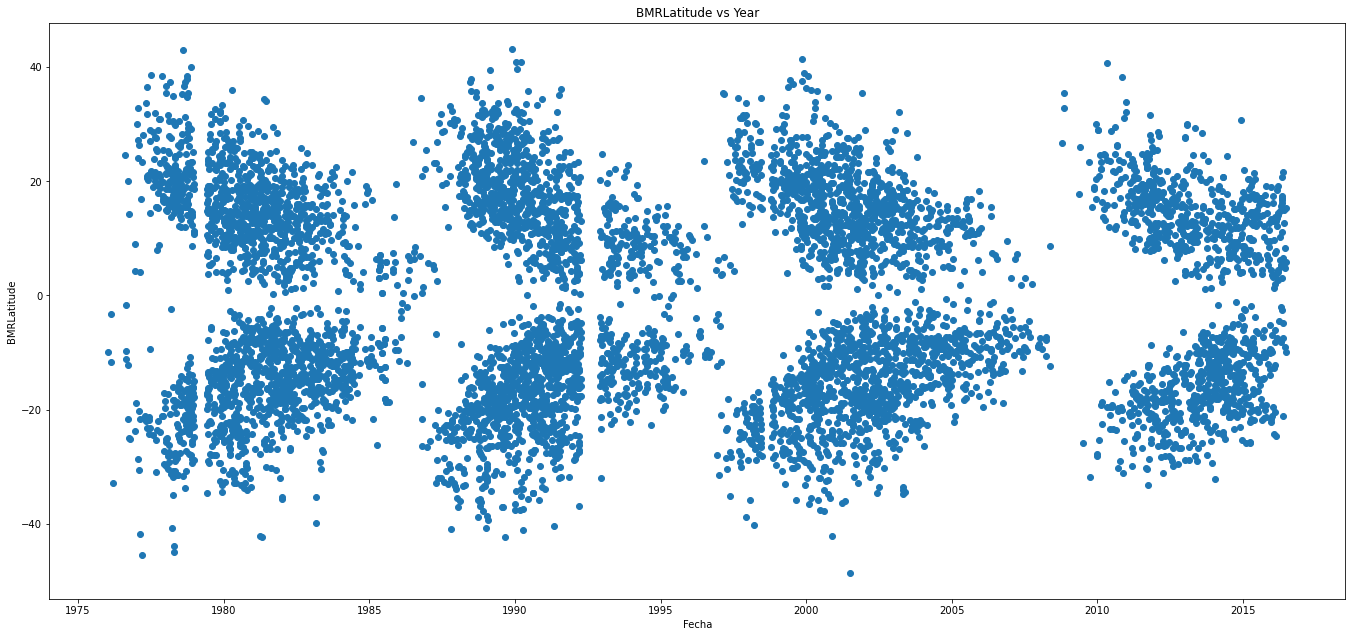

In [6]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 3, 2])
ax.scatter(df['Date'], df['BMRLatitude'], vmin=-90, vmax=90)
ax.set_title('BMRLatitude vs Year')
ax.set_xlabel('Fecha')
ax.set_ylabel('BMRLatitude')
plt.show()

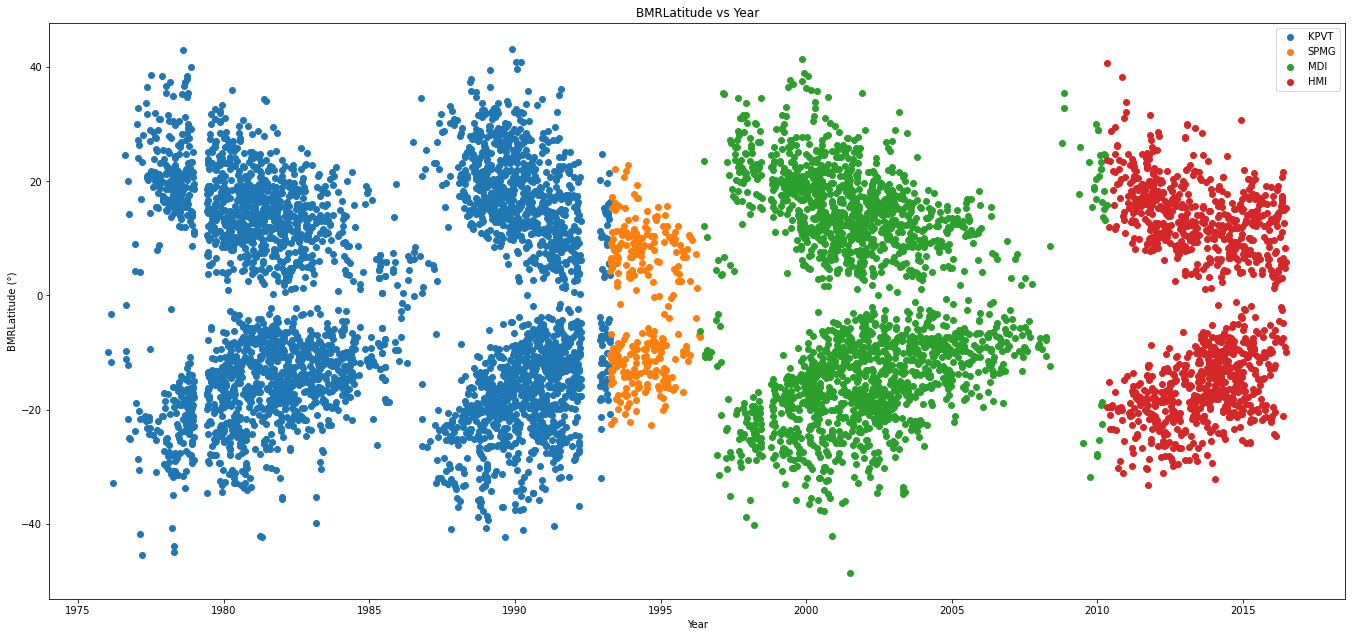

In [7]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 3, 2])
ax.scatter(KPVT['Date'], KPVT['BMRLatitude'], vmin=-90, vmax=90, label='KPVT')
ax.scatter(SPMG['Date'], SPMG['BMRLatitude'], vmin=-90, vmax=90, label='SPMG')
ax.scatter(MDI['Date'], MDI['BMRLatitude'], vmin=-90, vmax=90, label='MDI')
ax.scatter(HMI['Date'], HMI['BMRLatitude'], vmin=-90, vmax=90, label='HMI')
ax.set_title('BMRLatitude vs Year')
ax.set_xlabel('Year')
ax.set_ylabel('BMRLatitude (°)')
ax.legend()
plt.show()

In [8]:
hale_status = np.abs(df[df['AH_Status'] == 0]['BMRLatitude'])
anti_hale_status = np.abs(df[df['AH_Status'] == 1]['BMRLatitude'])
hh_ah_status = filters = np.array([hale_status, anti_hale_status], dtype=object)

In [9]:
count_hale = np.array([ 348., 1192., 1805., 1734., 1071.,  539.,  223.,   65.])
count_ahale = np.array([ 43.,  61.,  79., 104.,  53.,  42.,  14.,  11.])
data = np.array([count_hale, count_ahale])
a = pd.DataFrame(data, index=['Hale', 'AntiHale'], )
a

,0,1,2,3,4,5,6,7
Hale,348.0,1192.0,1805.0,1734.0,1071.0,539.0,223.0,65.0
AntiHale,43.0,61.0,79.0,104.0,53.0,42.0,14.0,11.0


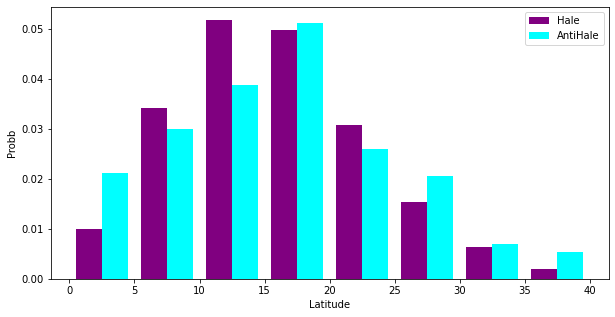

In [10]:
# HH-AH distribution

bins_lat_abs = np.linspace(0, 40, 9)

plt.figure(figsize=(10,5))
plt.hist(hh_ah_status, density=True, bins=bins_lat_abs, color=['purple','aqua'], histtype='bar', label=['Hale', 'AntiHale'])
plt.xlabel('Latitude')
plt.legend()
plt.ylabel('Probb')
plt.show()

# Identificador

In [11]:
# diferential rotation

def dif_rotation(lat):
    A = 14.713 # degrees/days
    B = -2.396 # degrees/days
    C = -1.787 # degrees/days
    c_r = 360 / 25.38 #degrees/days

    return(A - c_r + B * np.sin(np.pi * lat / 180)**2 + C * np.sin(np.pi * lat / 180)**4)

# identificador

def indentificador(mega_tabla, region, tol, d_before, d_after):
    temporal = pd.DataFrame()
    lon = region['BMRLongitude']
    lat = region['BMRLatitude']
    ref_day = region['ReferenceDay']

    rotation = dif_rotation(lat)
    
    bmr_latitude = mega_tabla['BMRLatitude']
    bmr_longitude = mega_tabla['BMRLongitude']

    rotation_diff = dif_rotation(bmr_latitude) - rotation
    corrected_longitude = rotation_diff * (mega_tabla['ReferenceDay'] - ref_day) + bmr_longitude

    corrected_longitude[corrected_longitude > 180] = corrected_longitude[corrected_longitude > 180] - 360
    corrected_longitude[corrected_longitude < -180] = corrected_longitude[corrected_longitude < -180] + 360

    # longitude correction

    mega_tabla['CorrectedLongitude'] = corrected_longitude

    # lat lim

    lat_up = lat > 180 - tol
    lat_down = lat < tol - 180

    if lat_up:
        lat_range = np.logical_or(mega_tabla['BMRLatitude'] < lat + tol - 360, lat - tol < mega_tabla['BMRLatitude'])
    elif lat_down:
        lat_range = np.logical_or(mega_tabla['BMRLatitude'] < lat + tol, 180 - tol + np.abs(-180 - lat) < mega_tabla['BMRLatitude'])
    else:
        lat_range = np.logical_and(mega_tabla['BMRLatitude'] < lat + tol, lat - tol < mega_tabla['BMRLatitude'])

    # lon lim

    lon_up = lon > 180 - tol
    lon_down = lon < tol - 180

    if lon_up:
        lon_range = np.logical_or(mega_tabla['CorrectedLongitude'] < lon + tol - 360, lon - tol < mega_tabla['CorrectedLongitude'])
    elif lon_down:
        lon_range = np.logical_or(mega_tabla['CorrectedLongitude'] < lon + tol, 180 - tol + np.abs(-180 - lon) < mega_tabla['CorrectedLongitude'])
    else:
        lon_range = np.logical_and(mega_tabla['CorrectedLongitude'] < lon + tol, lon - tol < mega_tabla['CorrectedLongitude'])

    latlon_range = np.logical_and(lat_range, lon_range)
    t_range = np.logical_and(mega_tabla['ReferenceDay'] < ref_day + d_after, ref_day - d_before < mega_tabla['ReferenceDay'])
    mask = np.logical_and(latlon_range, t_range)
    mask = np.logical_and(mask, mega_tabla['BMRLabel'] != region['BMRLabel'])
    mega_tabla_mask = mega_tabla[mask]

    temporal = temporal.append(mega_tabla_mask, ignore_index = True)

    # ids
    ids_np = region['BMRLabel'] * np.ones(len(mega_tabla_mask))
    ids = pd.DataFrame(ids_np)
    temporal['BMRid'] = ids

    # time
    time_np = region['ReferenceDay'] * np.ones(len(mega_tabla_mask))
    times = pd.DataFrame(time_np)[0]
    delta_time = temporal['ReferenceDay'] - times
    temporal['delta_time'] = delta_time

    # latitude
    lat_np = region['BMRLatitude'] * np.ones(len(mega_tabla_mask))
    latitudes = pd.DataFrame(lat_np)[0]
    delta_lat = temporal['BMRLatitude'] - latitudes
    temporal['delta_lat'] = delta_lat

    # longitude
    lon_np = region['BMRLongitude'] * np.ones(len(mega_tabla_mask))
    longitudes = pd.DataFrame(lon_np)[0]
    delta_lon = temporal['CorrectedLongitude'] - longitudes
    delta_lon[delta_lon > 180] = 360 - delta_lon[delta_lon > 180]
    delta_lon[delta_lon < -180] = -360 - delta_lon[delta_lon < -180]
    temporal['delta_lon'] = delta_lon


    return(temporal)

In [12]:
# params 

tol = [10,15,20,25] # latlon
d_tol = [30,60,90] # time

In [13]:
filters = np.empty((len(tol), len(d_tol)), dtype=object)

for i in range(len(tol)):
    for j in range(len(d_tol)):
        df_filter_hh = pd.DataFrame()
        df_filter_ah = pd.DataFrame()
        df_filter_gen = pd.DataFrame()
        
        for k in range(len(df)):
            region = df.iloc[k,0:]
            mask = indentificador(df, region, tol[i], d_tol[j], d_tol[j])
            
            if region['AH_21n'] or region['AH_21s'] or region['AH_22n'] or region['AH_22s']:
                df_filter_ah = df_filter_ah.append(mask, ignore_index = True)
            elif region['HH_21n'] or region['HH_21s'] or region['HH_22n'] or region['HH_22s']:
                df_filter_hh = df_filter_hh.append(mask, ignore_index = True)

            df_filter_gen = df_filter_gen.append(mask, ignore_index=True)

        df_filter = {'filter_hh' : df_filter_hh, 'filter_ah' : df_filter_ah, 'filter_gen' : df_filter_gen}
        filters[(i,j)] = df_filter

# Hist

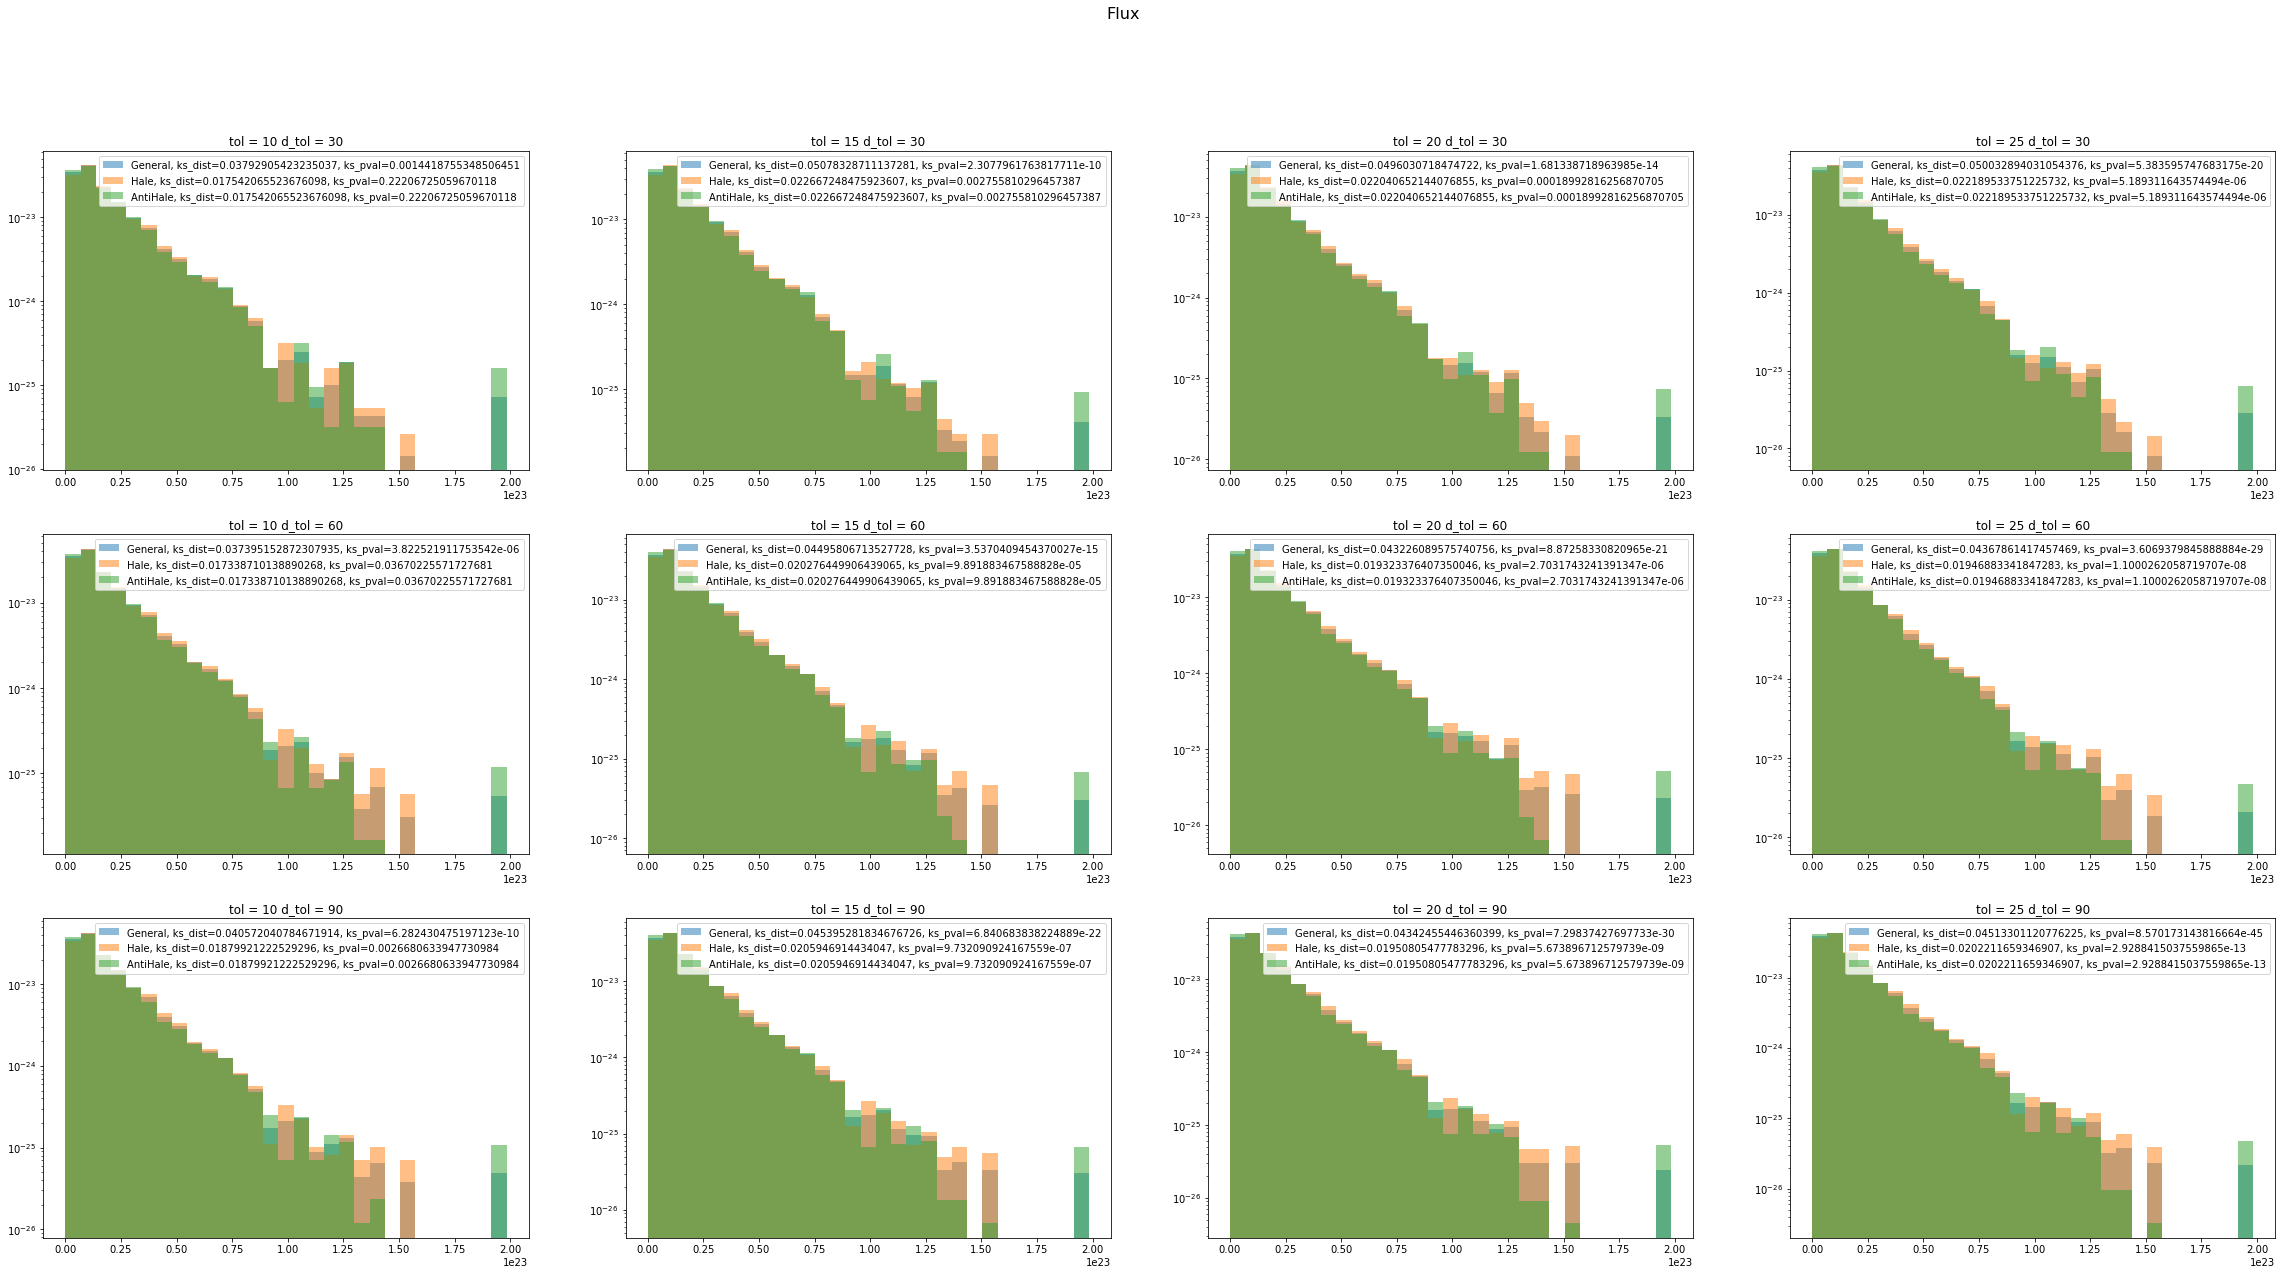

In [14]:
# flux

fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(40,20))
fig.suptitle('Flux', fontsize=16)

bins_flux = np.linspace(0, df['BMRFlux'].max(), 30)

for j in range(len(tol)):
    for i in range(len(d_tol)):
        flux_hh = filters[(j,i)]['filter_hh']['BMRFlux']
        flux_ah = filters[(j,i)]['filter_ah']['BMRFlux']
        flux_gen = filters[(j,i)]['filter_gen']['BMRFlux']
        ks_ah_hh = stats.ks_2samp(flux_hh, flux_ah)
        ks_gen_hh = stats.ks_2samp(flux_hh, flux_gen)
        ks_gen_ah = stats.ks_2samp(flux_hh, flux_gen)

        axs[i,j].hist(filters[(j,i)]['filter_gen']['BMRFlux'], density=True, alpha=0.5, bins=bins_flux, label='General, ks_dist='+str(ks_ah_hh[0])+', ks_pval='+str(ks_ah_hh[1]))
        axs[i,j].hist(filters[(j,i)]['filter_hh']['BMRFlux'], density=True, alpha=0.5, bins=bins_flux, label='Hale, ks_dist='+str(ks_gen_hh[0])+', ks_pval='+str(ks_gen_hh[1]))
        axs[i,j].hist(filters[(j,i)]['filter_ah']['BMRFlux'], density=True, alpha=0.5, bins=bins_flux, label='AntiHale, ks_dist='+str(ks_gen_ah[0])+', ks_pval='+str(ks_gen_ah[1]))
        axs[i,j].set_title('tol = ' + str(tol[j]) + ' d_tol = ' + str(d_tol[i]))
        axs[i,j].legend()
        axs[i,j].set_yscale('log')
        #axs[i,j].plot()
        #plt.show()


ks_flux_distance_ah_hh = pd.DataFrame(columns=tol, index=d_tol)
ks_flux_pvalue_ah_hh = pd.DataFrame(columns=tol, index=d_tol)

for j in range(len(tol)):
    for i in range(len(d_tol)):
        flux_hh = filters[(j,i)]['filter_hh']['BMRFlux']
        flux_ah = filters[(j,i)]['filter_ah']['BMRFlux']
        ks = stats.ks_2samp(flux_hh, flux_ah)
        ks_flux_distance_ah_hh[tol[j]][d_tol[i]] = ks[0]
        ks_flux_pvalue_ah_hh[tol[j]][d_tol[i]] = str(ks[1])

ks_flux_distance_gen_hh = pd.DataFrame(columns=tol, index=d_tol)
ks_flux_pvalue_gen_hh = pd.DataFrame(columns=tol, index=d_tol)

for j in range(len(tol)):
    for i in range(len(d_tol)):
        flux_gen = filters[(j,i)]['filter_gen']['BMRFlux']
        flux_hh = filters[(j,i)]['filter_hh']['BMRFlux']
        ks = stats.ks_2samp(flux_hh, flux_gen)
        ks_flux_distance_gen_hh[tol[j]][d_tol[i]] = ks[0]
        ks_flux_pvalue_gen_hh[tol[j]][d_tol[i]] = str(ks[1])

ks_flux_distance_gen_ah = pd.DataFrame(columns=tol, index=d_tol)
ks_flux_pvalue_gen_ah = pd.DataFrame(columns=tol, index=d_tol)

for j in range(len(tol)):
    for i in range(len(d_tol)):
        flux_gen = filters[(j,i)]['filter_gen']['BMRFlux']
        flux_ah = filters[(j,i)]['filter_ah']['BMRFlux']
        ks = stats.ks_2samp(flux_gen, flux_ah)
        ks_flux_distance_gen_ah[tol[j]][d_tol[i]] = ks[0]
        ks_flux_pvalue_gen_ah[tol[j]][d_tol[i]] = str(ks[1])

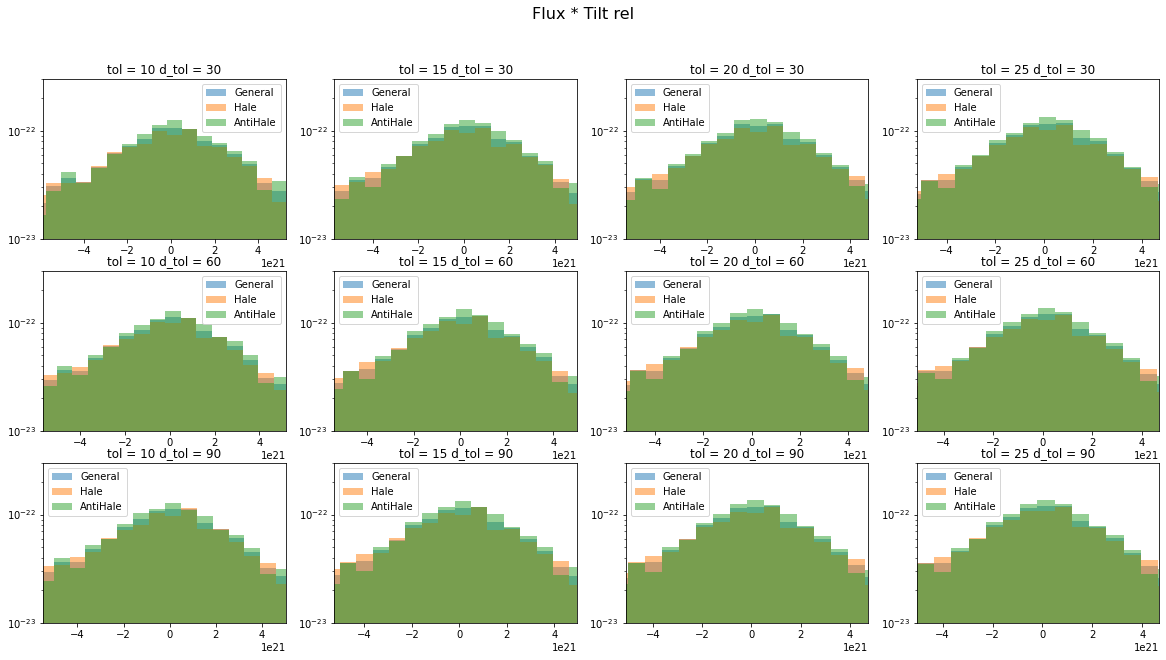

In [70]:
# flux x tilt rel

fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(20,10))
fig.suptitle('Flux * Tilt rel', fontsize=16)

t = df['BMRFlux'] * np.sin(df['Tilt_rel'] * np.pi/180)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
bins_flux_tilt = np.linspace(t.min(), t.max(), 300)

for j in range(len(tol)):
    for i in range(len(d_tol)):
        flux_x_tilt = filters[(j,i)]['filter_gen']['BMRFlux'] * np.sin(filters[(j,i)]['filter_gen']['Tilt_rel'] * np.pi/180)
        minimo = np.percentile(flux_x_tilt, 15)
        maximo = np.percentile(flux_x_tilt, 85)

        axs[i,j].hist(filters[(j,i)]['filter_gen']['BMRFlux'] * np.sin(filters[(j,i)]['filter_gen']['Tilt_rel'] * np.pi/180), density=True, bins=bins_flux_tilt, alpha=0.5, label='General')
        axs[i,j].hist(filters[(j,i)]['filter_hh']['BMRFlux'] * np.sin(filters[(j,i)]['filter_hh']['Tilt_rel'] * np.pi/180), density=True, bins=bins_flux_tilt, alpha=0.5, label='Hale')
        axs[i,j].hist(filters[(j,i)]['filter_ah']['BMRFlux'] * np.sin(filters[(j,i)]['filter_ah']['Tilt_rel'] * np.pi/180), density=True, bins=bins_flux_tilt, alpha=0.5, label='AntiHale')
        axs[i,j].set_xlim([minimo, maximo])
        axs[i,j].set_ylim([1e-23, 3e-22])
        axs[i,j].set_title('tol = ' + str(tol[j]) + ' d_tol = ' + str(d_tol[i]))
        axs[i,j].legend()
        axs[i,j].set_yscale('log')


ks_flux_tilt_distance_ah_hh = pd.DataFrame(columns=tol, index=d_tol)
ks_flux_tilt_pvalue_ah_hh = pd.DataFrame(columns=tol, index=d_tol)

for j in range(len(tol)):
    for i in range(len(d_tol)):
        flux_tilt_hh = filters[(j,i)]['filter_hh']['BMRFlux'] * np.sin(filters[(j,i)]['filter_hh']['Tilt_rel'] * np.pi/180)
        flux_tilt_ah = filters[(j,i)]['filter_ah']['BMRFlux'] * np.sin(filters[(j,i)]['filter_ah']['Tilt_rel'] * np.pi/180)
        ks = stats.ks_2samp(flux_tilt_hh, flux_tilt_ah)
        ks_flux_tilt_distance_ah_hh[tol[j]][d_tol[i]] = ks[0]
        ks_flux_tilt_pvalue_ah_hh[tol[j]][d_tol[i]] = str(ks[1])

ks_flux_tilt_distance_gen_hh = pd.DataFrame(columns=tol, index=d_tol)
ks_flux_tilt_pvalue_gen_hh = pd.DataFrame(columns=tol, index=d_tol)

for j in range(len(tol)):
    for i in range(len(d_tol)):
        flux_tilt_hh = filters[(j,i)]['filter_hh']['BMRFlux'] * np.sin(filters[(j,i)]['filter_hh']['Tilt_rel'] * np.pi/180)
        flux_tilt_gen = filters[(j,i)]['filter_gen']['BMRFlux'] * np.sin(filters[(j,i)]['filter_gen']['Tilt_rel'] * np.pi/180)
        ks = stats.ks_2samp(flux_tilt_hh, flux_tilt_gen)
        ks_flux_tilt_distance_gen_hh[tol[j]][d_tol[i]] = ks[0]
        ks_flux_tilt_pvalue_gen_hh[tol[j]][d_tol[i]] = str(ks[1])

ks_flux_tilt_distance_gen_ah = pd.DataFrame(columns=tol, index=d_tol)
ks_flux_tilt_pvalue_gen_ah = pd.DataFrame(columns=tol, index=d_tol)

for j in range(len(tol)):
    for i in range(len(d_tol)):
        flux_tilt_ah = filters[(j,i)]['filter_ah']['BMRFlux'] * np.sin(filters[(j,i)]['filter_ah']['Tilt_rel'] * np.pi/180)
        flux_tilt_gen = filters[(j,i)]['filter_gen']['BMRFlux'] * np.sin(filters[(j,i)]['filter_gen']['Tilt_rel'] * np.pi/180)
        ks = stats.ks_2samp(flux_tilt_ah, flux_tilt_gen)
        ks_flux_tilt_distance_gen_ah[tol[j]][d_tol[i]] = ks[0]
        ks_flux_tilt_pvalue_gen_ah[tol[j]][d_tol[i]] = str(ks[1])


In [16]:
ks_flux_tilt_distance_ah_hh

,10,15,20,25
30,0.047665,0.060442,0.057408,0.056779
60,0.047403,0.054043,0.048171,0.049539
90,0.050119,0.05444,0.050177,0.048942


In [17]:
ks_flux_tilt_pvalue_ah_hh

,10,15,20,25
30,2.201399909773638e-05,1.709743457922741e-14,2.7996715771314314e-19,1.2487954569982367e-25
60,1.2989636068506208e-09,9.60927837165783e-22,1.0570930924663788e-25,2.1090647294310247e-37
90,6.31670575900902e-15,2.6666088368175357e-31,9.83736305220743e-40,1.3325076751764105e-52


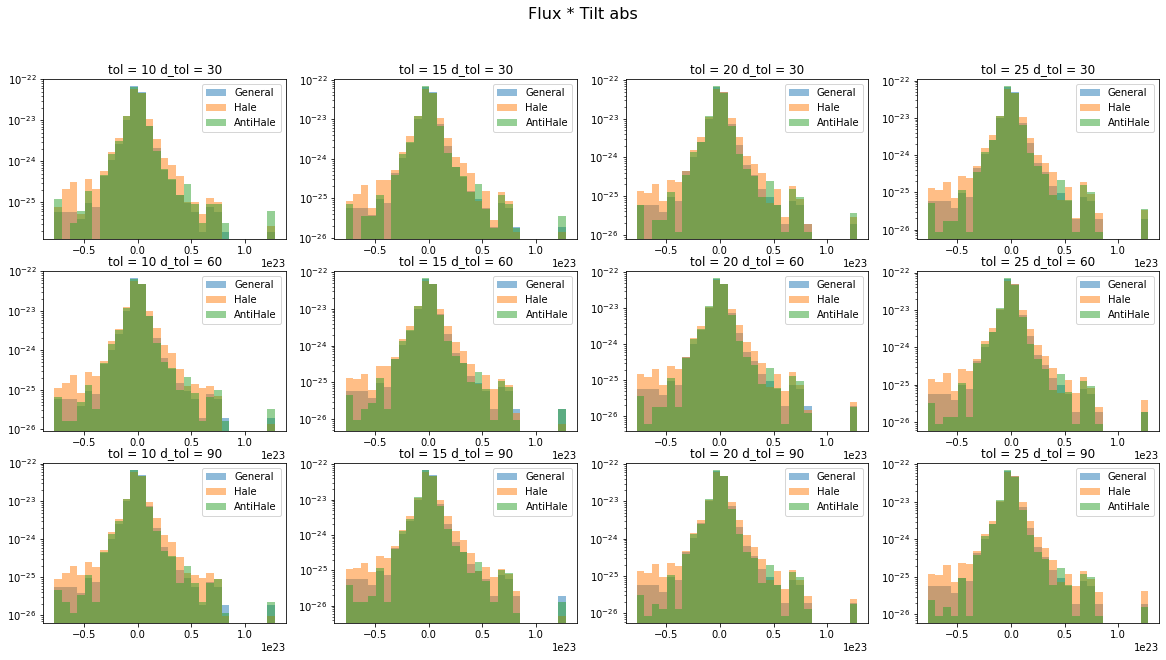

In [18]:
# flux x tilt abs

fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(20,10))
fig.suptitle('Flux * Tilt abs', fontsize=16)

t = df['BMRFlux'] * np.sin(df['Tilt_abs'] * np.pi/180)
bins_flux_tilt = np.linspace(t.min(), t.max(), 30)

for j in range(len(tol)):
    for i in range(len(d_tol)):
        axs[i,j].hist(df['BMRFlux'] * np.sin(df['Tilt_abs'] * np.pi/180), density=True, bins=bins_flux_tilt, alpha=0.5, label='General')
        axs[i,j].hist(filters[(j,i)]['filter_hh']['BMRFlux'] * np.sin(filters[(j,i)]['filter_hh']['Tilt_abs'] * np.pi/180), density=True, bins=bins_flux_tilt, alpha=0.5, label='Hale')
        axs[i,j].hist(filters[(j,i)]['filter_ah']['BMRFlux'] * np.sin(filters[(j,i)]['filter_ah']['Tilt_abs'] * np.pi/180), density=True, bins=bins_flux_tilt, alpha=0.5, label='AntiHale')
        axs[i,j].set_title('tol = ' + str(tol[j]) + ' d_tol = ' + str(d_tol[i]))
        axs[i,j].legend()
        axs[i,j].set_yscale('log')

ks_flux_tilt_distance_ah_hh = pd.DataFrame(columns=tol, index=d_tol)
ks_flux_tilt_pvalue_ah_hh = pd.DataFrame(columns=tol, index=d_tol)

for j in range(len(tol)):
    for i in range(len(d_tol)):
        flux_tilt_hh = filters[(j,i)]['filter_hh']['BMRFlux'] * np.sin(filters[(j,i)]['filter_hh']['Tilt_abs'] * np.pi/180)
        flux_tilt_ah = filters[(j,i)]['filter_ah']['BMRFlux'] * np.sin(filters[(j,i)]['filter_ah']['Tilt_abs'] * np.pi/180)
        ks = stats.ks_2samp(flux_tilt_hh, flux_tilt_ah)
        ks_flux_tilt_distance_ah_hh[tol[j]][d_tol[i]] = ks[0]
        ks_flux_tilt_pvalue_ah_hh[tol[j]][d_tol[i]] = str(ks[1])

ks_flux_tilt_distance_gen_hh = pd.DataFrame(columns=tol, index=d_tol)
ks_flux_tilt_pvalue_gen_hh = pd.DataFrame(columns=tol, index=d_tol)

for j in range(len(tol)):
    for i in range(len(d_tol)):
        flux_tilt_hh = filters[(j,i)]['filter_hh']['BMRFlux'] * np.sin(filters[(j,i)]['filter_hh']['Tilt_abs'] * np.pi/180)
        flux_tilt_gen = filters[(j,i)]['filter_gen']['BMRFlux'] * np.sin(filters[(j,i)]['filter_gen']['Tilt_abs'] * np.pi/180)
        ks = stats.ks_2samp(flux_tilt_hh, flux_tilt_gen)
        ks_flux_tilt_distance_gen_hh[tol[j]][d_tol[i]] = ks[0]
        ks_flux_tilt_pvalue_gen_hh[tol[j]][d_tol[i]] = str(ks[1])

ks_flux_tilt_distance_gen_ah = pd.DataFrame(columns=tol, index=d_tol)
ks_flux_tilt_pvalue_gen_ah = pd.DataFrame(columns=tol, index=d_tol)

for j in range(len(tol)):
    for i in range(len(d_tol)):
        flux_tilt_ah = filters[(j,i)]['filter_ah']['BMRFlux'] * np.sin(filters[(j,i)]['filter_ah']['Tilt_abs'] * np.pi/180)
        flux_tilt_gen = filters[(j,i)]['filter_gen']['BMRFlux'] * np.sin(filters[(j,i)]['filter_gen']['Tilt_abs'] * np.pi/180)
        ks = stats.ks_2samp(flux_tilt_ah, flux_tilt_gen)
        ks_flux_tilt_distance_gen_ah[tol[j]][d_tol[i]] = ks[0]
        ks_flux_tilt_pvalue_gen_ah[tol[j]][d_tol[i]] = str(ks[1])

In [19]:
ks_flux_tilt_distance_ah_hh

,10,15,20,25
30,0.070088,0.078899,0.083746,0.083272
60,0.068549,0.075167,0.078507,0.079282
90,0.074029,0.077113,0.079405,0.079788


In [20]:
ks_flux_tilt_pvalue_ah_hh

,10,15,20,25
30,3.8756997611244515e-11,2.0645193995516522e-24,1.433176013435811e-40,1.1332831170355849e-54
60,1.2219890995072568e-19,1.1053062413754868e-41,1.3183666092313798e-67,3.354964825079736e-95
90,4.506969129234957e-32,2.0938844966808712e-62,6.1874229484595115e-99,3.3432562890901524e-139


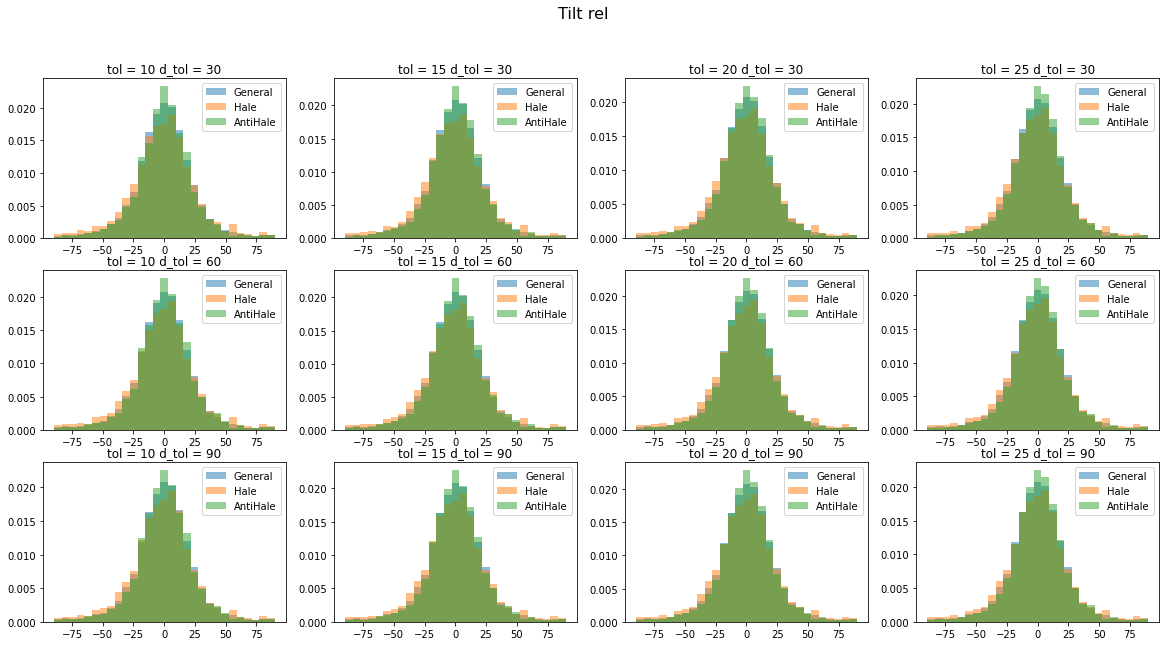

In [21]:
# tilt rel

fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(20,10))
fig.suptitle('Tilt rel', fontsize=16)

bins_tilt_rel = np.linspace(df['Tilt_rel'].min(), df['Tilt_rel'].max(), 30)

for j in range(len(tol)):
    for i in range(len(d_tol)):
        axs[i,j].hist(df['Tilt_rel'], density=True, alpha=0.5, bins=bins_tilt_rel, label='General')
        axs[i,j].hist(filters[(j,i)]['filter_hh']['Tilt_rel'], density=True, alpha=0.5, bins=bins_tilt_rel, label='Hale')
        axs[i,j].hist(filters[(j,i)]['filter_ah']['Tilt_rel'], density=True, alpha=0.5, bins=bins_tilt_rel, label='AntiHale')
        axs[i,j].set_title('tol = ' + str(tol[j]) + ' d_tol = ' + str(d_tol[i]))
        axs[i,j].legend()

ks_tilt_rel_distance_ah_hh = pd.DataFrame(columns=tol, index=d_tol)
ks_tilt_rel_pvalue_ah_hh = pd.DataFrame(columns=tol, index=d_tol)

for j in range(len(tol)):
    for i in range(len(d_tol)):
        tilt_rel_hh = filters[(j,i)]['filter_hh']['Tilt_rel']
        tilt_rel_ah = filters[(j,i)]['filter_ah']['Tilt_rel']
        ks = stats.ks_2samp(tilt_rel_hh, tilt_rel_ah)
        ks_tilt_rel_distance_ah_hh[tol[j]][d_tol[i]] = ks[0]
        ks_tilt_rel_pvalue_ah_hh[tol[j]][d_tol[i]] = str(ks[1])

ks_tilt_rel_distance_gen_hh = pd.DataFrame(columns=tol, index=d_tol)
ks_tilt_rel_pvalue_gen_hh = pd.DataFrame(columns=tol, index=d_tol)

for j in range(len(tol)):
    for i in range(len(d_tol)):
        tilt_rel_hh = filters[(j,i)]['filter_hh']['Tilt_rel']
        tilt_rel_gen = filters[(j,i)]['filter_gen']['Tilt_rel']
        ks = stats.ks_2samp(tilt_rel_hh, tilt_rel_gen)
        ks_tilt_rel_distance_gen_hh[tol[j]][d_tol[i]] = ks[0]
        ks_tilt_rel_pvalue_gen_hh[tol[j]][d_tol[i]] = str(ks[1])

ks_tilt_rel_distance_gen_ah = pd.DataFrame(columns=tol, index=d_tol)
ks_tilt_rel_pvalue_gen_ah = pd.DataFrame(columns=tol, index=d_tol)

for j in range(len(tol)):
    for i in range(len(d_tol)):
        tilt_rel_ah = filters[(j,i)]['filter_ah']['Tilt_rel']
        tilt_rel_gen = filters[(j,i)]['filter_gen']['Tilt_rel']
        ks = stats.ks_2samp(tilt_rel_ah, tilt_rel_gen)
        ks_tilt_rel_distance_gen_ah[tol[j]][d_tol[i]] = ks[0]
        ks_tilt_rel_pvalue_gen_ah[tol[j]][d_tol[i]] = str(ks[1])

In [22]:
ks_tilt_rel_distance_ah_hh

,10,15,20,25
30,0.057495,0.067339,0.063627,0.06198
60,0.060871,0.062653,0.058889,0.055766
90,0.058699,0.060704,0.057591,0.053346


In [23]:
ks_tilt_rel_pvalue_ah_hh

,10,15,20,25
30,1.2304157126497017e-07,6.79713744755944e-18,1.376672971754463e-23,1.8397163641902442e-30
60,1.418962184594364e-15,4.4192890619417244e-29,3.3054138663728557e-38,2.7473229833787843e-47
90,2.565579378568559e-20,8.096188551578483e-39,3.2510329808108557e-52,2.0325039332642034e-62


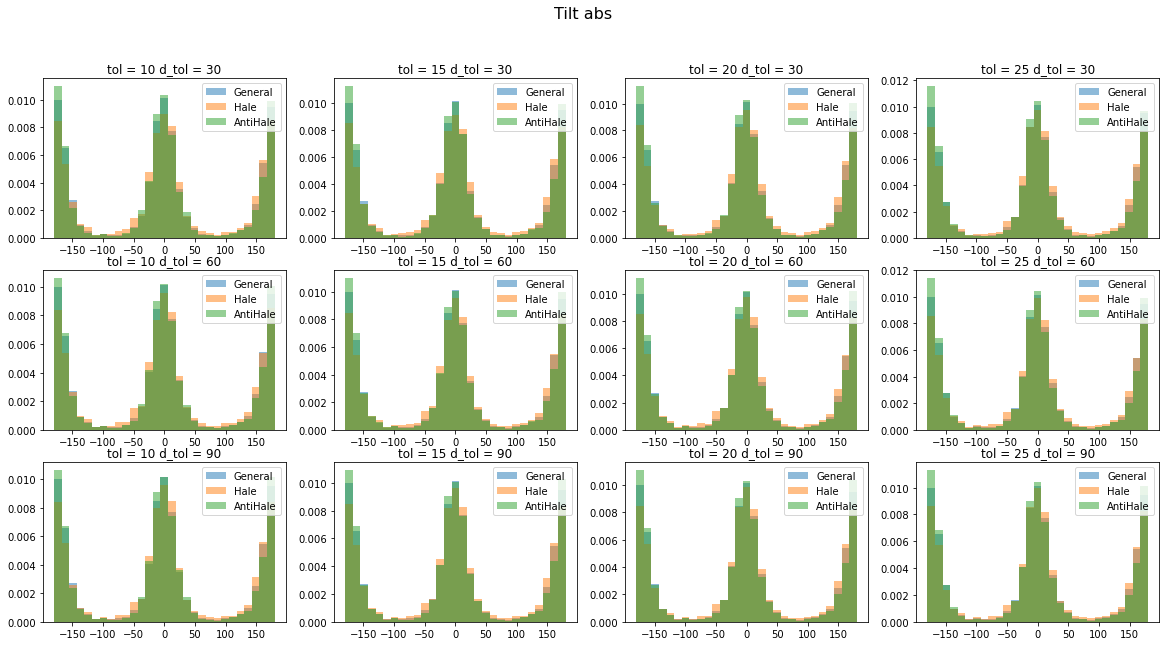

In [24]:
# tilt abs

fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(20,10))
fig.suptitle('Tilt abs', fontsize=16)

bins_tilt_abs = np.linspace(df['Tilt_abs'].min(), df['Tilt_abs'].max(), 30)

for j in range(len(tol)):
    for i in range(len(d_tol)):
        axs[i,j].hist(df['Tilt_abs'], density=True, alpha=0.5, bins=bins_tilt_abs, label='General')
        axs[i,j].hist(filters[(j,i)]['filter_hh']['Tilt_abs'], density=True, alpha=0.5, bins=bins_tilt_abs, label='Hale')
        axs[i,j].hist(filters[(j,i)]['filter_ah']['Tilt_abs'], density=True, alpha=0.5, bins=bins_tilt_abs, label='AntiHale')
        axs[i,j].set_title('tol = ' + str(tol[j]) + ' d_tol = ' + str(d_tol[i]))
        axs[i,j].legend()

ks_tilt_abs_distance_ah_hh = pd.DataFrame(columns=tol, index=d_tol)
ks_tilt_abs_pvalue_ah_hh = pd.DataFrame(columns=tol, index=d_tol)

for j in range(len(tol)):
    for i in range(len(d_tol)):
        tilt_abs_hh = filters[(j,i)]['filter_hh']['Tilt_abs']
        tilt_abs_ah = filters[(j,i)]['filter_ah']['Tilt_abs']
        ks = stats.ks_2samp(tilt_abs_hh, tilt_abs_ah)
        ks_tilt_abs_distance_ah_hh[tol[j]][d_tol[i]] = ks[0]
        ks_tilt_abs_pvalue_ah_hh[tol[j]][d_tol[i]] = str(ks[1])

ks_tilt_abs_distance_gen_hh = pd.DataFrame(columns=tol, index=d_tol)
ks_tilt_abs_pvalue_gen_hh = pd.DataFrame(columns=tol, index=d_tol)

for j in range(len(tol)):
    for i in range(len(d_tol)):
        tilt_abs_hh = filters[(j,i)]['filter_hh']['Tilt_abs']
        tilt_abs_gen = filters[(j,i)]['filter_gen']['Tilt_abs']
        ks = stats.ks_2samp(tilt_abs_hh, tilt_abs_gen)
        ks_tilt_abs_distance_gen_hh[tol[j]][d_tol[i]] = ks[0]
        ks_tilt_abs_pvalue_gen_hh[tol[j]][d_tol[i]] = str(ks[1])

ks_tilt_abs_distance_gen_ah = pd.DataFrame(columns=tol, index=d_tol)
ks_tilt_abs_pvalue_gen_ah = pd.DataFrame(columns=tol, index=d_tol)

for j in range(len(tol)):
    for i in range(len(d_tol)):
        tilt_abs_ah = filters[(j,i)]['filter_ah']['Tilt_abs']
        tilt_abs_gen = filters[(j,i)]['filter_gen']['Tilt_abs']
        ks = stats.ks_2samp(tilt_abs_ah, tilt_abs_gen)
        ks_tilt_abs_distance_gen_ah[tol[j]][d_tol[i]] = ks[0]
        ks_tilt_abs_pvalue_gen_ah[tol[j]][d_tol[i]] = str(ks[1])

In [25]:
ks_tilt_abs_distance_ah_hh

,10,15,20,25
30,0.051362,0.061464,0.061267,0.065848
60,0.048347,0.056042,0.055442,0.058738
90,0.046489,0.051381,0.053325,0.055296


In [26]:
ks_tilt_abs_pvalue_ah_hh

,10,15,20,25
30,3.5074395107193013e-06,1.0325074129013956e-14,6.699050463683931e-22,2.4900545810773683e-34
60,5.549361323112508e-10,2.3782002267805847e-23,6.518888395086256e-34,2.0318195988447957e-52
90,6.676239469452866e-13,6.305182858301412e-28,8.011036621948742e-45,4.897632639261657e-67


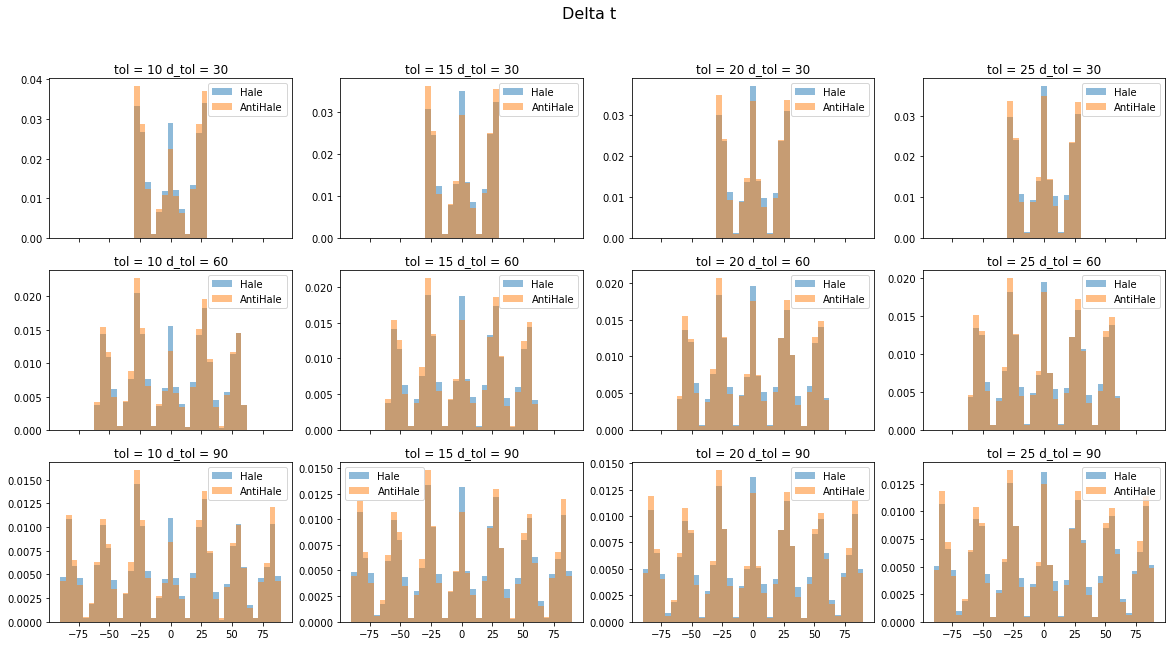

In [27]:
# delta_time

fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(20,10), sharex=True)
fig.suptitle('Delta t', fontsize=16)

bins_delta_t = np.linspace(-90, 90, 40)

for j in range(len(tol)):
    for i in range(len(d_tol)):
        axs[i,j].hist(filters[(j,i)]['filter_hh']['delta_time'], density=True, alpha=0.5, bins=bins_delta_t, label='Hale')
        axs[i,j].hist(filters[(j,i)]['filter_ah']['delta_time'], density=True, alpha=0.5, bins=bins_delta_t, label='AntiHale')
        axs[i,j].set_title('tol = ' + str(tol[j]) + ' d_tol = ' + str(d_tol[i]))
        axs[i,j].legend()

ks_delta_time_distance = pd.DataFrame(columns=tol, index=d_tol)
ks_delta_time_pvalue = pd.DataFrame(columns=tol, index=d_tol)

for j in range(len(tol)):
    for i in range(len(d_tol)):
        delta_time_hh = filters[(j,i)]['filter_hh']['delta_time']
        delta_time_ah = filters[(j,i)]['filter_ah']['delta_time']
        ks = stats.ks_2samp(delta_time_hh, delta_time_ah)
        ks_delta_time_distance[tol[j]][d_tol[i]] = ks[0]
        ks_delta_time_pvalue[tol[j]][d_tol[i]] = str(ks[1])

In [28]:
ks_delta_time_distance

,10,15,20,25
30,0.035485,0.029651,0.023849,0.022491
60,0.026932,0.024504,0.018047,0.016966
90,0.017122,0.018227,0.014559,0.013487


In [29]:
ks_delta_time_pvalue

,10,15,20,25
30,0.0035489069789613747,0.0008117305676691444,0.001109227288120792,0.0002210746794914305
60,0.002152870458395982,8.256695704232634e-05,0.0005642725812143564,9.176073966406829e-05
90,0.04038311871200462,0.0006892156758347881,0.000977909063155927,0.0002178868690637111


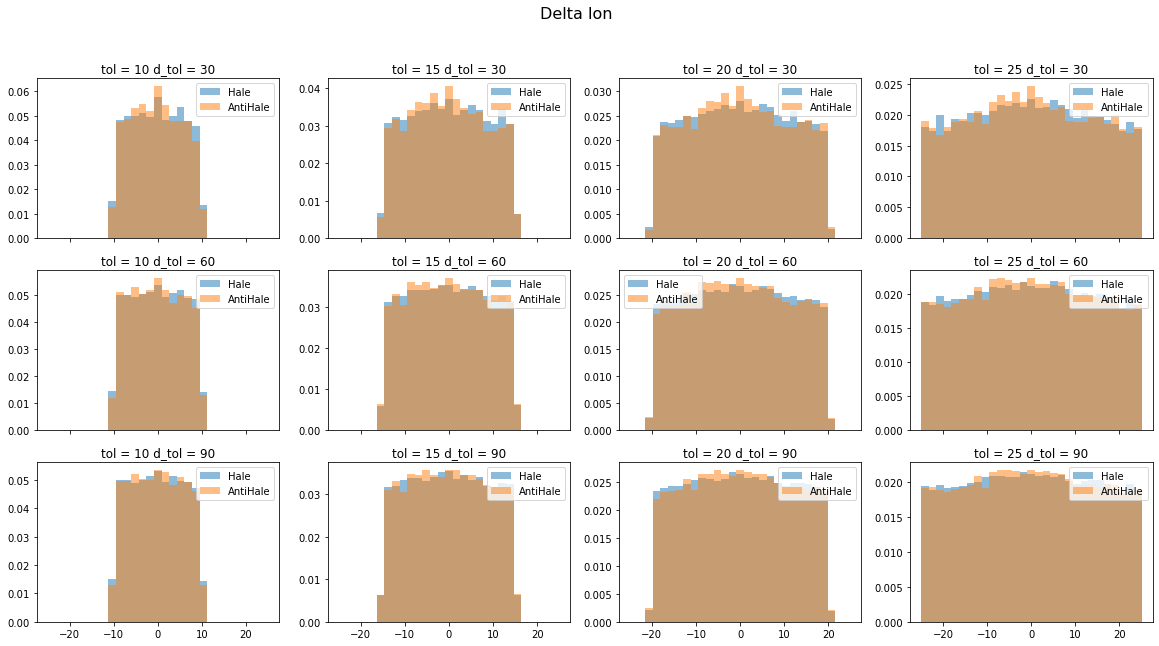

In [30]:
# delta_lon

fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(20,10), sharex=True)
fig.suptitle('Delta lon', fontsize=16)

bins_delta_t = np.linspace(-25, 25, 30)

for j in range(len(tol)):
    for i in range(len(d_tol)):
        axs[i,j].hist(filters[(j,i)]['filter_hh']['delta_lon'], density=True, alpha=0.5, bins=bins_delta_t, label='Hale')
        axs[i,j].hist(filters[(j,i)]['filter_ah']['delta_lon'], density=True, alpha=0.5, bins=bins_delta_t, label='AntiHale')
        axs[i,j].set_title('tol = ' + str(tol[j]) + ' d_tol = ' + str(d_tol[i]))
        axs[i,j].legend()

ks_delta_lon_distance = pd.DataFrame(columns=tol, index=d_tol)
ks_delta_lon_pvalue = pd.DataFrame(columns=tol, index=d_tol)

for j in range(len(tol)):
    for i in range(len(d_tol)):
        delta_lon_hh = filters[(j,i)]['filter_hh']['delta_lon']
        delta_lon_ah = filters[(j,i)]['filter_ah']['delta_lon']
        ks = stats.ks_2samp(delta_lon_hh, delta_lon_ah)
        ks_delta_lon_distance[tol[j]][d_tol[i]] = ks[0]
        ks_delta_lon_pvalue[tol[j]][d_tol[i]] = str(ks[1])

In [31]:
ks_delta_lon_distance

,10,15,20,25
30,0.029649,0.023361,0.015674,0.012489
60,0.015001,0.01291,0.010066,0.007171
90,0.007982,0.009964,0.007615,0.006437


In [32]:
ks_delta_lon_pvalue

,10,15,20,25
30,0.02391902143613056,0.015630458970927075,0.07821101165118283,0.12010741188490703
60,0.23860736820940032,0.12087690460890343,0.15679032936737636,0.33323574590717764
90,0.7885017093420736,0.18392004889368363,0.2474667634462695,0.2491290079559828


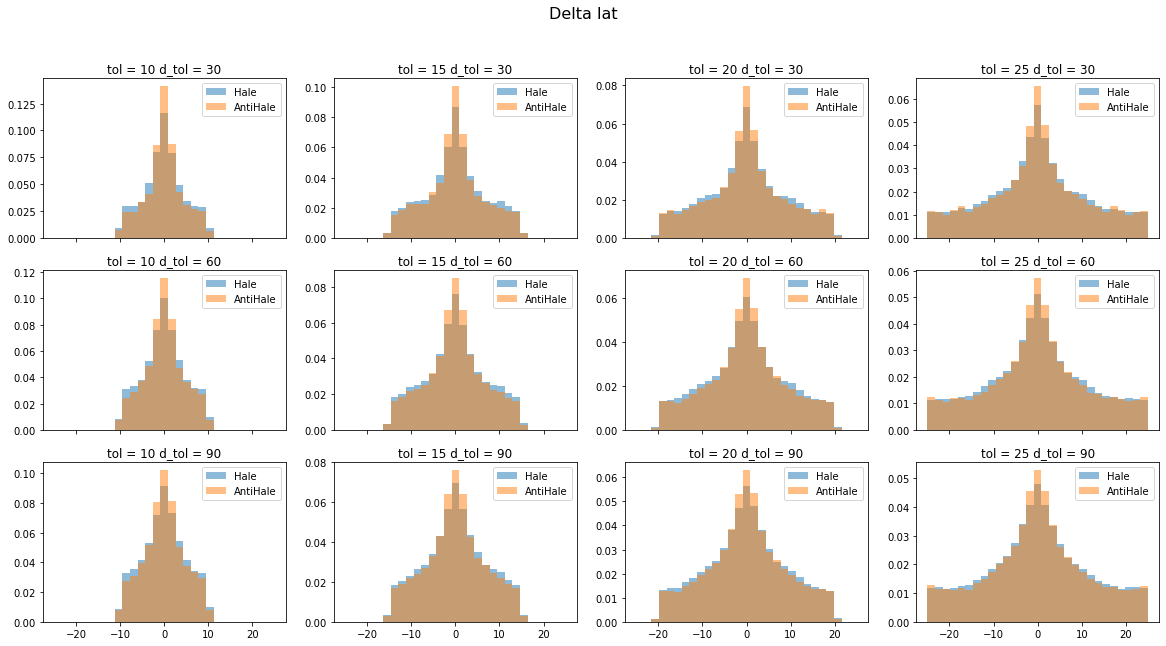

In [33]:
# delta_lat

fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(20,10), sharex=True)
fig.suptitle('Delta lat', fontsize=16)

bins_delta_t = np.linspace(-25, 25, 30)

for j in range(len(tol)):
    for i in range(len(d_tol)):
        axs[i,j].hist(filters[(j,i)]['filter_hh']['delta_lat'], density=True, alpha=0.5, bins=bins_delta_t, label='Hale')
        axs[i,j].hist(filters[(j,i)]['filter_ah']['delta_lat'], density=True, alpha=0.5, bins=bins_delta_t, label='AntiHale')
        axs[i,j].set_title('tol = ' + str(tol[j]) + ' d_tol = ' + str(d_tol[i]))
        axs[i,j].legend()

ks_delta_lat_distance = pd.DataFrame(columns=tol, index=d_tol)
ks_delta_lat_pvalue = pd.DataFrame(columns=tol, index=d_tol)

for j in range(len(tol)):
    for i in range(len(d_tol)):
        delta_lat_hh = filters[(j,i)]['filter_hh']['delta_lat']
        delta_lat_ah = filters[(j,i)]['filter_ah']['delta_lat']
        ks = stats.ks_2samp(delta_lat_hh, delta_lat_ah)
        ks_delta_lat_distance[tol[j]][d_tol[i]] = ks[0]
        ks_delta_lat_pvalue[tol[j]][d_tol[i]] = str(ks[1])

In [34]:
ks_delta_lat_distance

,10,15,20,25
30,0.040217,0.030182,0.021366,0.017815
60,0.030854,0.024102,0.022065,0.017712
90,0.02648,0.022461,0.018815,0.014521


In [35]:
ks_delta_lat_pvalue

,10,15,20,25
30,0.0005878588175870503,0.0006124765072744731,0.004865372468256879,0.0065724593161684665
60,0.0002551858047469319,0.00011466490916254992,9.908916537159015e-06,3.7407992604545185e-05
90,0.00017829863616881437,1.1081005705779288e-05,5.933578172839524e-06,5.093174801661239e-05


# Hist2d

In [36]:
filters_type = ['filter_hh', 'filter_gen', 'filter_ah']

In [37]:
if os.path.exists('HIST_2D'):
    None
else:
    os.mkdir('HIST_2D')

In [65]:
# flux

bins_flux = np.linspace(0, df['BMRFlux'].max(), 300)
bins_lat_abs = np.linspace(0, np.abs(df['BMRLatitude']).max(), 300)

for region_id in range(len(filters_type)):
    fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(30,20))
    fig.suptitle('Flux '+filters_type[region_id], fontsize=30)
    for j in range(len(tol)):
        for i in range(len(d_tol)):
            axs[i,j].hist2d(filters[(j,i)][filters_type[region_id]]['BMRFlux'], np.abs(filters[(j,i)][filters_type[region_id]]['BMRLatitude']), bins=(bins_flux, bins_lat_abs))
            axs[i,j].set_xlabel('Flux')
            axs[i,j].set_ylabel('abs(BMRLatitude)')
            axs[i,j].set_xlim([0.0,1e23])
            axs[i,j].set_title('tol = ' + str(tol[j]) + ' d_tol = ' + str(d_tol[i]))
    fig.savefig('HIST_2D/'+'Flux_'+str(region_id)+'.png', bbox_inches='tight')
    plt.close(fig)

In [68]:
# flux x tilt rel

t = df['BMRFlux'] * np.sin(df['Tilt_rel'] * np.pi/180)
bins_flux_tilt = np.linspace(t.min(), t.max(), 300)
bins_lat_abs = np.linspace(0, np.abs(df['BMRLatitude']).max(), 30)

for region_id in range(len(filters_type)):
    fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(30,20))
    fig.suptitle('Flux * Tilt rel '+filters_type[region_id], fontsize=30)
    for j in range(len(tol)):
        for i in range(len(d_tol)):
            flux_x_tilt = filters[(j,i)]['filter_gen']['BMRFlux'] * np.sin(filters[(j,i)]['filter_gen']['Tilt_rel'] * np.pi/180)
            minimo = np.percentile(flux_x_tilt, 15)
            maximo = np.percentile(flux_x_tilt, 85)

            axs[i,j].hist2d(filters[(j,i)][filters_type[region_id]]['BMRFlux'] * np.sin(filters[(j,i)][filters_type[region_id]]['Tilt_rel'] * np.pi/180), np.abs(filters[(j,i)][filters_type[region_id]]['BMRLatitude']), bins=(bins_flux_tilt, bins_lat_abs))
            axs[i,j].set_title('tol = ' + str(tol[j]) + ' d_tol = ' + str(d_tol[i]))
            axs[i,j].set_xlim([minimo,maximo])
            axs[i,j].set_xlabel('Flux * Tilt_rel')
            axs[i,j].set_ylabel('abs(BMRLatitude)')
    fig.savefig('HIST_2D/'+'Flux_Tilt_rel_'+str(region_id)+'.png', bbox_inches='tight')
    plt.close(fig)

In [40]:
# tilt rel

bins_tilt_rel = np.linspace(0, df['Tilt_rel'].max(), 30)
bins_lat_abs = np.linspace(0, np.abs(df['BMRLatitude']).max(), 30)

for region_id in range(len(filters_type)):
    fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(30,20))
    fig.suptitle('Tilt rel '+filters_type[region_id], fontsize=30)
    for j in range(len(tol)):
        for i in range(len(d_tol)):
            axs[i,j].hist2d(filters[(j,i)][filters_type[region_id]]['Tilt_rel'], np.abs(filters[(j,i)][filters_type[region_id]]['BMRLatitude']), bins=(bins_tilt_rel, bins_lat_abs))
            axs[i,j].set_xlabel('Tilt rel')
            axs[i,j].set_ylabel('abs(BMRLatitude)')
            axs[i,j].set_title('tol = ' + str(tol[j]) + ' d_tol = ' + str(d_tol[i]))
    fig.savefig('HIST_2D/'+'Tilt_rel_'+str(region_id)+'.png', bbox_inches='tight')
    plt.close(fig)

In [41]:
# tilt abs

bins_tilt_abs = np.linspace(0, df['Tilt_abs'].max(), 30)
bins_lat_abs = np.linspace(0, np.abs(df['BMRLatitude']).max(), 30)

for region_id in range(len(filters_type)):
    fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(30,20))
    fig.suptitle('Tilt abs '+filters_type[region_id], fontsize=30)
    for j in range(len(tol)):
        for i in range(len(d_tol)):
            axs[i,j].hist2d(filters[(j,i)][filters_type[region_id]]['Tilt_abs'], np.abs(filters[(j,i)][filters_type[region_id]]['BMRLatitude']), bins=(bins_tilt_abs, bins_lat_abs))
            axs[i,j].set_xlabel('Tilt abs')
            axs[i,j].set_ylabel('abs(BMRLatitude)')
            axs[i,j].set_title('tol = ' + str(tol[j]) + ' d_tol = ' + str(d_tol[i]))
    fig.savefig('HIST_2D/'+'Tilt_abs_'+str(region_id)+'.png', bbox_inches='tight')
    plt.close(fig)

# Hist 2D full

In [42]:
if os.path.exists('HIST_2D_full'):
    None
else:
    os.mkdir('HIST_2D_full')

In [43]:
# flux

bins_flux = np.linspace(0, df['BMRFlux'].max(), 30)
bins_lat_abs = np.linspace(0, np.abs(df['BMRLatitude']).max(), 30)

for region_id in range(len(filters_type)):
    fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(30,20))
    fig.suptitle('Flux '+filters_type[region_id], fontsize=30)
    for j in range(len(tol)):
        for i in range(len(d_tol)):
            axs[i,j].hist2d(filters[(j,i)][filters_type[region_id]]['BMRFlux'], filters[(j,i)][filters_type[region_id]]['BMRLatitude'], bins=(bins_flux, bins_lat_abs))
            axs[i,j].set_xlabel('Flux')
            axs[i,j].set_ylabel('abs(BMRLatitude)')
            axs[i,j].set_xlim([0.0,1e23])
            axs[i,j].set_title('tol = ' + str(tol[j]) + ' d_tol = ' + str(d_tol[i]))
    fig.savefig('HIST_2D_full/'+'Flux_'+str(region_id)+'.png', bbox_inches='tight')
    plt.close(fig)

In [44]:
# flux x tilt rel

t = df['BMRFlux'] * np.sin(df['Tilt_rel'] * np.pi/180)
bins_flux_tilt = np.linspace(t.min(), t.max(), 30)
bins_lat_abs = np.linspace(0, np.abs(df['BMRLatitude']).max(), 30)

for region_id in range(len(filters_type)):
    fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(30,20))
    fig.suptitle('Flux * Tilt rel '+filters_type[region_id], fontsize=30)
    for j in range(len(tol)):
        for i in range(len(d_tol)):
            flux_x_tilt = filters[(j,i)]['filter_gen']['BMRFlux'] * np.sin(filters[(j,i)]['filter_gen']['Tilt_rel'] * np.pi/180)
            minimo = np.percentile(flux_x_tilt, 0.5)
            maximo = np.percentile(flux_x_tilt, 99.5)

            axs[i,j].hist2d(filters[(j,i)][filters_type[region_id]]['BMRFlux'] * np.sin(filters[(j,i)][filters_type[region_id]]['Tilt_rel'] * np.pi/180), filters[(j,i)][filters_type[region_id]]['BMRLatitude'], bins=(bins_flux_tilt, bins_lat_abs))
            axs[i,j].set_title('tol = ' + str(tol[j]) + ' d_tol = ' + str(d_tol[i]))
            axs[i,j].set_xlim([minimo,maximo])
            axs[i,j].set_xlabel('Flux * Tilt_rel')
            axs[i,j].set_ylabel('abs(BMRLatitude)')
    fig.savefig('HIST_2D_full/'+'Flux_Tilt_rel_'+str(region_id)+'.png', bbox_inches='tight')
    plt.close(fig)

In [45]:
# tilt rel

bins_tilt_rel = np.linspace(0, df['Tilt_rel'].max(), 30)
bins_lat_abs = np.linspace(0, np.abs(df['BMRLatitude']).max(), 30)

for region_id in range(len(filters_type)):
    fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(30,20))
    fig.suptitle('Tilt rel '+filters_type[region_id], fontsize=30)
    for j in range(len(tol)):
        for i in range(len(d_tol)):
            axs[i,j].hist2d(filters[(j,i)][filters_type[region_id]]['Tilt_rel'], filters[(j,i)][filters_type[region_id]]['BMRLatitude'], bins=(bins_tilt_rel, bins_lat_abs))
            axs[i,j].set_xlabel('Tilt rel')
            axs[i,j].set_ylabel('abs(BMRLatitude)')
            axs[i,j].set_title('tol = ' + str(tol[j]) + ' d_tol = ' + str(d_tol[i]))
    fig.savefig('HIST_2D_full/'+'Tilt_rel_'+str(region_id)+'.png', bbox_inches='tight')
    plt.close(fig)

In [46]:
# tilt abs

bins_tilt_abs = np.linspace(0, df['Tilt_abs'].max(), 30)
bins_lat_abs = np.linspace(0, np.abs(df['BMRLatitude']).max(), 30)

for region_id in range(len(filters_type)):
    fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(30,20))
    fig.suptitle('Tilt abs '+filters_type[region_id], fontsize=30)
    for j in range(len(tol)):
        for i in range(len(d_tol)):
            axs[i,j].hist2d(filters[(j,i)][filters_type[region_id]]['Tilt_abs'], filters[(j,i)][filters_type[region_id]]['BMRLatitude'], bins=(bins_tilt_abs, bins_lat_abs))
            axs[i,j].set_xlabel('Tilt abs')
            axs[i,j].set_ylabel('abs(BMRLatitude)')
            axs[i,j].set_title('tol = ' + str(tol[j]) + ' d_tol = ' + str(d_tol[i]))
    fig.savefig('HIST_2D_full/'+'Tilt_abs_'+str(region_id)+'.png', bbox_inches='tight')
    plt.close(fig)

# Contour

In [47]:
if os.path.exists('CONTOUR'):
    None
else:
    os.mkdir('CONTOUR')

In [48]:
# flux

bins_flux = np.linspace(0, df['BMRFlux'].max(), 30)
bins_lat_abs = np.linspace(0, np.abs(df['BMRLatitude']).max(), 30)

for region_id in range(len(filters_type)):
    fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(30,20))
    fig.suptitle('Flux '+filters_type[region_id], fontsize=30)
    for j in range(len(tol)):
        for i in range(len(d_tol)):
            counts,xbins,ybins,image = axs[i,j].hist2d(filters[(j,i)][filters_type[region_id]]['BMRFlux'], np.abs(filters[(j,i)][filters_type[region_id]]['BMRLatitude']), bins=(bins_flux, bins_lat_abs), alpha=0.7)
            axs[i,j].contour(np.transpose(counts),extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()])
            axs[i,j].set_xlim([0.0,1e23])
            axs[i,j].set_xlabel('Flux')
            axs[i,j].set_ylabel('abs(BMRLatitude)')
            axs[i,j].set_title('tol = ' + str(tol[j]) + ' d_tol = ' + str(d_tol[i]))
    fig.savefig('CONTOUR/'+'Flux_'+str(region_id)+'.png', bbox_inches='tight')
    plt.close(fig)

In [49]:
# flux x tilt rel

t = df['BMRFlux'] * np.sin(df['Tilt_rel'] * np.pi/180)
bins_flux_tilt = np.linspace(t.min(), t.max(), 30)
bins_lat_abs = np.linspace(0, np.abs(df['BMRLatitude']).max(), 30)

for region_id in range(len(filters_type)):
    fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(30,20))
    fig.suptitle('Flux * Tilt rel '+filters_type[region_id], fontsize=30)
    for j in range(len(tol)):
        for i in range(len(d_tol)):
            flux_x_tilt = filters[(j,i)]['filter_gen']['BMRFlux'] * np.sin(filters[(j,i)]['filter_gen']['Tilt_rel'] * np.pi/180)
            minimo = np.percentile(flux_x_tilt, 0.5)
            maximo = np.percentile(flux_x_tilt, 99.5)

            counts,xbins,ybins,image = axs[i,j].hist2d(filters[(j,i)][filters_type[region_id]]['BMRFlux'] * np.sin(filters[(j,i)][filters_type[region_id]]['Tilt_rel'] * np.pi/180), np.abs(filters[(j,i)][filters_type[region_id]]['BMRLatitude']), bins=(bins_flux_tilt, bins_lat_abs), alpha=0.7)
            axs[i,j].contour(np.transpose(counts),extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()])
            axs[i,j].set_xlim([minimo,maximo])
            axs[i,j].set_title('tol = ' + str(tol[j]) + ' d_tol = ' + str(d_tol[i]))
            axs[i,j].set_xlabel('Flux * Tilt_rel')
            axs[i,j].set_ylabel('abs(BMRLatitude)')
    fig.savefig('CONTOUR/'+'Flux_Tilt_rel_'+str(region_id)+'.png', bbox_inches='tight')
    plt.close(fig)

In [50]:
# tilt rel

bins_tilt_rel = np.linspace(0, df['Tilt_rel'].max(), 30)
bins_lat_abs = np.linspace(0, np.abs(df['BMRLatitude']).max(), 30)

for region_id in range(len(filters_type)):
    fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(30,20))
    fig.suptitle('Tilt rel '+filters_type[region_id], fontsize=30)
    for j in range(len(tol)):
        for i in range(len(d_tol)):
            counts,xbins,ybins,image = axs[i,j].hist2d(filters[(j,i)][filters_type[region_id]]['Tilt_rel'], np.abs(filters[(j,i)][filters_type[region_id]]['BMRLatitude']), bins=(bins_tilt_rel, bins_lat_abs), alpha=0.7)
            axs[i,j].contour(np.transpose(counts),extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()])
            axs[i,j].set_xlabel('Tilt rel')
            axs[i,j].set_ylabel('abs(BMRLatitude)')
            axs[i,j].set_title('tol = ' + str(tol[j]) + ' d_tol = ' + str(d_tol[i]))
    fig.savefig('CONTOUR/'+'Tilt_rel_'+str(region_id)+'.png', bbox_inches='tight')
    plt.close(fig)

In [51]:
# tilt abs

bins_tilt_abs = np.linspace(0, df['Tilt_abs'].max(), 30)
bins_lat_abs = np.linspace(0, np.abs(df['BMRLatitude']).max(), 30)

for region_id in range(len(filters_type)):
    fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(30,20))
    fig.suptitle('Tilt abs '+filters_type[region_id], fontsize=30)
    for j in range(len(tol)):
        for i in range(len(d_tol)):
            counts,xbins,ybins,image = axs[i,j].hist2d(filters[(j,i)][filters_type[region_id]]['Tilt_abs'], np.abs(filters[(j,i)][filters_type[region_id]]['BMRLatitude']), bins=(bins_tilt_abs, bins_lat_abs), alpha=0.7)
            axs[i,j].contour(np.transpose(counts),extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()])
            axs[i,j].set_xlabel('Tilt abs')
            axs[i,j].set_ylabel('abs(BMRLatitude)')
            axs[i,j].set_title('tol = ' + str(tol[j]) + ' d_tol = ' + str(d_tol[i]))
    fig.savefig('CONTOUR/'+'Tilt_abs_'+str(region_id)+'.png', bbox_inches='tight')
    plt.close(fig)

# Contour full

In [52]:
if os.path.exists('CONTOUR_full'):
    None
else:
    os.mkdir('CONTOUR_full')

In [53]:
# flux

bins_flux = np.linspace(0, df['BMRFlux'].max(), 30)
bins_lat = np.linspace(df['BMRLatitude'].min(), df['BMRLatitude'].max(), 30)

for region_id in range(len(filters_type)):
    fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(30,20))
    fig.suptitle('Flux '+filters_type[region_id], fontsize=30)
    for j in range(len(tol)):
        for i in range(len(d_tol)):
            counts,xbins,ybins,image = axs[i,j].hist2d(filters[(j,i)][filters_type[region_id]]['BMRFlux'], filters[(j,i)][filters_type[region_id]]['BMRLatitude'], bins=(bins_flux, bins_lat), alpha=0.7)
            axs[i,j].contour(np.transpose(counts),extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()])
            axs[i,j].set_xlim([0.0,1e23])
            axs[i,j].set_xlabel('Flux')
            axs[i,j].set_ylabel('abs(BMRLatitude)')
            axs[i,j].set_title('tol = ' + str(tol[j]) + ' d_tol = ' + str(d_tol[i]))
    fig.savefig('CONTOUR_full/'+'Flux_'+str(region_id)+'.png', bbox_inches='tight')
    plt.close(fig)

In [54]:
# flux x tilt rel

t = df['BMRFlux'] * np.sin(df['Tilt_rel'] * np.pi/180)
bins_flux_tilt = np.linspace(t.min(), t.max(), 30)
bins_lat = np.linspace(df['BMRLatitude'].min(), df['BMRLatitude'].max(), 30)

for region_id in range(len(filters_type)):
    fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(30,20))
    fig.suptitle('Flux * Tilt rel '+filters_type[region_id], fontsize=30)
    for j in range(len(tol)):
        for i in range(len(d_tol)):
            flux_x_tilt = filters[(j,i)]['filter_gen']['BMRFlux'] * np.sin(filters[(j,i)]['filter_gen']['Tilt_rel'] * np.pi/180)
            minimo = np.percentile(flux_x_tilt, 0.5)
            maximo = np.percentile(flux_x_tilt, 99.5)

            counts,xbins,ybins,image = axs[i,j].hist2d(filters[(j,i)][filters_type[region_id]]['BMRFlux'] * np.sin(filters[(j,i)][filters_type[region_id]]['Tilt_rel'] * np.pi/180), filters[(j,i)][filters_type[region_id]]['BMRLatitude'], bins=(bins_flux_tilt, bins_lat), alpha=0.7)
            axs[i,j].contour(np.transpose(counts),extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()])
            axs[i,j].set_xlim([minimo,maximo])
            axs[i,j].set_title('tol = ' + str(tol[j]) + ' d_tol = ' + str(d_tol[i]))
            axs[i,j].set_xlabel('Flux * Tilt_rel')
            axs[i,j].set_ylabel('abs(BMRLatitude)')
    fig.savefig('CONTOUR_full/'+'Flux_Tilt_rel_'+str(region_id)+'.png', bbox_inches='tight')
    plt.close(fig)

In [55]:
# tilt rel

bins_tilt_rel = np.linspace(0, df['Tilt_rel'].max(), 30)
bins_lat = np.linspace(df['BMRLatitude'].min(), df['BMRLatitude'].max(), 30)

for region_id in range(len(filters_type)):
    fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(30,20))
    fig.suptitle('Tilt rel '+filters_type[region_id], fontsize=30)
    for j in range(len(tol)):
        for i in range(len(d_tol)):
            counts,xbins,ybins,image = axs[i,j].hist2d(filters[(j,i)][filters_type[region_id]]['Tilt_rel'], filters[(j,i)][filters_type[region_id]]['BMRLatitude'], bins=(bins_tilt_rel, bins_lat), alpha=0.7)
            axs[i,j].contour(np.transpose(counts),extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()])
            axs[i,j].set_xlabel('Tilt rel')
            axs[i,j].set_ylabel('abs(BMRLatitude)')
            axs[i,j].set_title('tol = ' + str(tol[j]) + ' d_tol = ' + str(d_tol[i]))
    fig.savefig('CONTOUR_full/'+'Tilt_rel_'+str(region_id)+'.png', bbox_inches='tight')
    plt.close(fig)

In [56]:
# tilt abs

bins_tilt_abs = np.linspace(0, df['Tilt_abs'].max(), 30)
bins_lat = np.linspace(df['BMRLatitude'].min(), df['BMRLatitude'].max(), 30)

for region_id in range(len(filters_type)):
    fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(30,20))
    fig.suptitle('Tilt abs '+filters_type[region_id], fontsize=30)
    for j in range(len(tol)):
        for i in range(len(d_tol)):
            counts,xbins,ybins,image = axs[i,j].hist2d(filters[(j,i)][filters_type[region_id]]['Tilt_abs'], filters[(j,i)][filters_type[region_id]]['BMRLatitude'], bins=(bins_tilt_abs, bins_lat), alpha=0.7)
            axs[i,j].contour(np.transpose(counts),extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()])
            axs[i,j].set_xlabel('Tilt abs')
            axs[i,j].set_ylabel('abs(BMRLatitude)')
            axs[i,j].set_title('tol = ' + str(tol[j]) + ' d_tol = ' + str(d_tol[i]))
    fig.savefig('CONTOUR_full/'+'Tilt_abs_'+str(region_id)+'.png', bbox_inches='tight')
    plt.close(fig)

# Diferencias HH-AH

## HH - GENERAL

In [57]:
filters_hh_ah = ['filter_hh', 'filter_ah']

In [58]:
if os.path.exists('GENERAL-HH'):
    None
else:
    os.mkdir('GENERAL-HH')

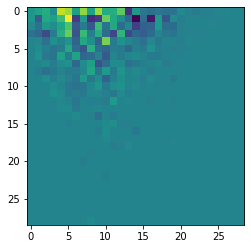

In [62]:
f_gen = np.histogram2d(filters[(1,1)]['filter_gen']['BMRFlux'], np.abs(filters[(1,1)]['filter_gen']['BMRLatitude']), bins=(bins_flux, bins_lat_abs), density=True)
f_hh = np.histogram2d(filters[(1,1)]['filter_hh']['BMRFlux'], np.abs(filters[(1,1)]['filter_hh']['BMRLatitude']), bins=(bins_flux, bins_lat_abs), density=True)

diff = f_gen[0] - f_hh[0]

plt.imshow(diff)

In [60]:
# flux

bins_flux = np.linspace(0, df['BMRFlux'].max(), 30)
bins_lat_abs = np.linspace(0, np.abs(df['BMRLatitude']).max(), 30)

for region_id in range(len(filters_hh_ah)):
    fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(30,20))
    fig.suptitle('Flux '+filters_type[region_id], fontsize=30)
    for j in range(len(tol)):
        for i in range(len(d_tol)):
            counts,xbins,ybins,image = axs[i,j].hist2d(filters[(j,i)][filters_type[region_id]]['BMRFlux'], np.abs(filters[(j,i)][filters_type[region_id]]['BMRLatitude']), bins=(bins_flux, bins_lat_abs), alpha=0.7)
            axs[i,j].contour(np.transpose(counts),extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()])
            axs[i,j].set_xlim([0.0,1e23])
            axs[i,j].set_xlabel('Flux')
            axs[i,j].set_ylabel('abs(BMRLatitude)')
            axs[i,j].set_title('tol = ' + str(tol[j]) + ' d_tol = ' + str(d_tol[i]))
    fig.savefig('CONTOUR/'+'Flux_'+str(region_id)+'.png', bbox_inches='tight')
    plt.close(fig)